In [0]:
!pip install -q keras
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from IPython.display import SVG, clear_output
from keras.utils import plot_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

from sklearn import preprocessing

In [0]:
from google.colab import auth
from googleapiclient.discovery import build
import io , requests, os
import sys
auth.authenticate_user()
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
K.tensorflow_backend._get_available_gpus()

[]

In [0]:

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

# define path to save model
model_path = 'regression_model.h5'

In [0]:


# read training data - It is the aircraft engine run-to-failure data.
file_id = '1FMQWVp_3OMC7vcystS0Jx0ki8ctOUs5P'
downloaded = drive.CreateFile({'id': file_id})
downloaded = drive.CreateFile({'id':'1FMQWVp_3OMC7vcystS0Jx0ki8ctOUs5P'}) # replace the id with id of file you want to access
downloaded.GetContentFile('xyz.csv')  
train_df = pd.read_csv('xyz.csv', sep=" ", header=None)
#print(train_df)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
train_df = train_df.sort_values(['id','cycle'])

# read test data - It is the aircraft engine operating data without failure events recorded.
file_id = '1LUsj1NpRD-3OCDlqxoVrX4f1Bg-UrjxJ'
downloaded = drive.CreateFile({'id': file_id})
downloaded = drive.CreateFile({'id':file_id}) # replace the id with id of file you want to access
downloaded.GetContentFile('xyz.csv')  
test_df = pd.read_csv('xyz.csv', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
file_id = '1EIH_wNvfAuNNSKLFuKNPlWKiX2wvBe8O'
downloaded = drive.CreateFile({'id': file_id})
downloaded = drive.CreateFile({'id':file_id}) # replace the id with id of file you want to access
downloaded.GetContentFile('xyz.csv')  
truth_df = pd.read_csv('xyz.csv', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)


In [0]:
# Data Labeling - generate column RUL
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)


# MinMax normalization
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)

join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

In [0]:
# MinMax normalization
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
print(test_df.head())

# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)


   id  cycle  setting1  setting2  setting3   s1        s2        s3        s4  \
0   1      1  0.632184  0.750000       0.0  0.0  0.545181  0.310661  0.269413   
1   1      2  0.344828  0.250000       0.0  0.0  0.150602  0.379551  0.222316   
2   1      3  0.517241  0.583333       0.0  0.0  0.376506  0.346632  0.322248   
3   1      4  0.741379  0.500000       0.0  0.0  0.370482  0.285154  0.408001   
4   1      5  0.580460  0.500000       0.0  0.0  0.391566  0.352082  0.332039   

    s5     ...           s13       s14       s15  s16       s17  s18  s19  \
0  0.0     ...      0.220588  0.132160  0.308965  0.0  0.333333  0.0  0.0   
1  0.0     ...      0.264706  0.204768  0.213159  0.0  0.416667  0.0  0.0   
2  0.0     ...      0.220588  0.155640  0.458638  0.0  0.416667  0.0  0.0   
3  0.0     ...      0.250000  0.170090  0.257022  0.0  0.250000  0.0  0.0   
4  0.0     ...      0.220588  0.152751  0.300885  0.0  0.166667  0.0  0.0   

        s20       s21  cycle_norm  
0  0.558140  0

In [0]:
# pick a large window size of 50 cycles
sequence_length = 50

def gen_sequence(id_df, seq_length, seq_cols):
   
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 from row 0 to row 50
    # 1 51 from row 1 to row 51
    # 2 52 from row 2 to row 52
    # ...
    # 111 191 from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]
        

In [0]:
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

val=list(gen_sequence(train_df[train_df['id']==1], sequence_length, sequence_cols))
print(len(val))

# transform each id of the train dataset in a sequence
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# generate sequences and convert to np array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

142
(15631, 50, 25)


In [0]:
# generate labels
def gen_labels(id_df, seq_length, label):
   
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape


(15631, 1)

In [0]:
def r2_keras(y_true, y_pred):
   
    res =  K.sum(K.square( y_true - y_pred ))
    tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - res/(tot + K.epsilon()) )


In [0]:
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [0]:
# Next, we build a deep network. 
# The first layer ==> LSTM layer with 100 units
# Second Layer ==>  LSTM layer with 50 units. 
# Dropout is applied after each LSTM layer to control overfitting. 
# Final layer is a Dense output layer with single unit and Relu activation.
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()
model.add(Conv1D(filters=30, kernel_size=10, padding='same', activation='relu',
                 input_shape=(sequence_length, nb_features)))
model.add(MaxPooling1D(pool_size=1))

model.add(Conv1D(filters=30, kernel_size=10, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(LSTM(
          units=100,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mae',r2_keras])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 50, 30)            7530      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 50, 30)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 50, 30)            9030      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 25, 30)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               52400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
__________

In [0]:
# plot
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []        
        self.fig = plt.figure()        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, np.sqrt(self.losses), label="loss")
        plt.plot(self.x, np.sqrt(self.val_losses), label="val_loss")
        plt.ylabel('loss - RMSE')
        plt.xlabel('epoch')
        plt.legend(['train','test'], loc='upper left')
        plt.title('model loss = ' + str(min(np.sqrt(self.val_losses))))
        plt.show();
        
plot_losses = PlotLosses()

In [0]:
# fit the network
history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          
                   )

# list all data in history
print(history.history.keys())

#history.save('lstm_rul.h5') 

Train on 14849 samples, validate on 782 samples
Epoch 1/100
 - 11s - loss: 8573.7331 - mean_absolute_error: 73.7420 - r2_keras: -1.6377e+00 - val_loss: 7492.4512 - val_mean_absolute_error: 68.0106 - val_r2_keras: -2.1388e+00
Epoch 2/100
 - 11s - loss: 7191.2879 - mean_absolute_error: 65.8242 - r2_keras: -1.2141e+00 - val_loss: 6590.3787 - val_mean_absolute_error: 62.8297 - val_r2_keras: -1.7167e+00
Epoch 3/100
 - 11s - loss: 6380.1579 - mean_absolute_error: 61.2245 - r2_keras: -9.6259e-01 - val_loss: 5862.2007 - val_mean_absolute_error: 58.7058 - val_r2_keras: -1.3824e+00
Epoch 4/100
 - 11s - loss: 5714.3624 - mean_absolute_error: 57.5315 - r2_keras: -7.5780e-01 - val_loss: 5268.2608 - val_mean_absolute_error: 55.3995 - val_r2_keras: -1.1158e+00
Epoch 5/100
 - 11s - loss: 5169.5756 - mean_absolute_error: 54.5351 - r2_keras: -5.9109e-01 - val_loss: 4784.9217 - val_mean_absolute_error: 52.7630 - val_r2_keras: -9.0484e-01
Epoch 6/100
 - 11s - loss: 4727.3622 - mean_absolute_error: 52.2193

 - 21s - loss: 1020.2983 - mean_absolute_error: 18.3895 - r2_keras: 0.6901 - val_loss: 919.5095 - val_mean_absolute_error: 18.1872 - val_r2_keras: 0.6840
Epoch 25/100
 - 21s - loss: 960.9338 - mean_absolute_error: 17.8282 - r2_keras: 0.7074 - val_loss: 863.1779 - val_mean_absolute_error: 17.0359 - val_r2_keras: 0.7064
Epoch 26/100
 - 24s - loss: 937.1568 - mean_absolute_error: 17.9327 - r2_keras: 0.7136 - val_loss: 810.2256 - val_mean_absolute_error: 16.0251 - val_r2_keras: 0.7233
Epoch 27/100
 - 23s - loss: 885.7345 - mean_absolute_error: 17.2927 - r2_keras: 0.7304 - val_loss: 805.3315 - val_mean_absolute_error: 16.1288 - val_r2_keras: 0.7237
Epoch 28/100
 - 29s - loss: 859.7168 - mean_absolute_error: 17.2503 - r2_keras: 0.7382 - val_loss: 816.4577 - val_mean_absolute_error: 18.4218 - val_r2_keras: 0.6836
Epoch 29/100
 - 33s - loss: 833.2630 - mean_absolute_error: 17.0293 - r2_keras: 0.7469 - val_loss: 730.9445 - val_mean_absolute_error: 16.3708 - val_r2_keras: 0.7361
Epoch 30/100
 - 

 - 32s - loss: 478.9431 - mean_absolute_error: 13.5779 - r2_keras: 0.8539 - val_loss: 677.9575 - val_mean_absolute_error: 16.6730 - val_r2_keras: 0.6807
Epoch 49/100
 - 32s - loss: 448.8012 - mean_absolute_error: 13.0351 - r2_keras: 0.8629 - val_loss: 655.4159 - val_mean_absolute_error: 16.6435 - val_r2_keras: 0.6707
Epoch 50/100
 - 33s - loss: 477.1052 - mean_absolute_error: 13.6352 - r2_keras: 0.8542 - val_loss: 772.5832 - val_mean_absolute_error: 16.8216 - val_r2_keras: 0.6597
Epoch 51/100
 - 32s - loss: 456.3943 - mean_absolute_error: 13.3307 - r2_keras: 0.8606 - val_loss: 786.5855 - val_mean_absolute_error: 18.0356 - val_r2_keras: 0.6465
['loss', 'mean_absolute_error', 'val_r2_keras', 'val_mean_absolute_error', 'r2_keras', 'val_loss']


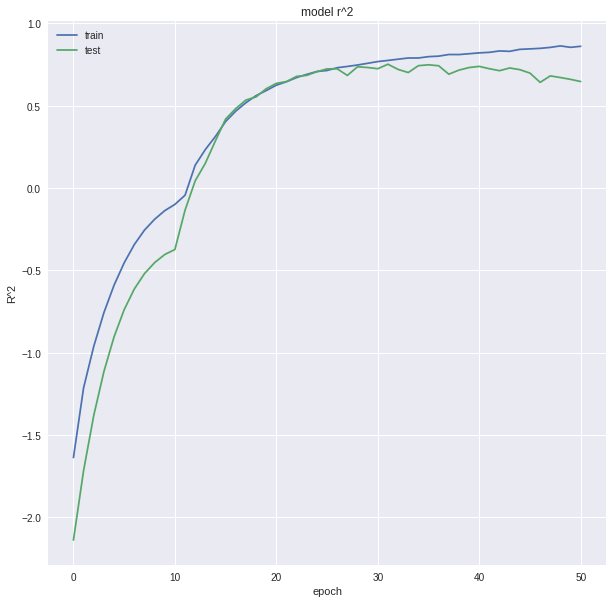

In [0]:
# summarize for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_r2.png")

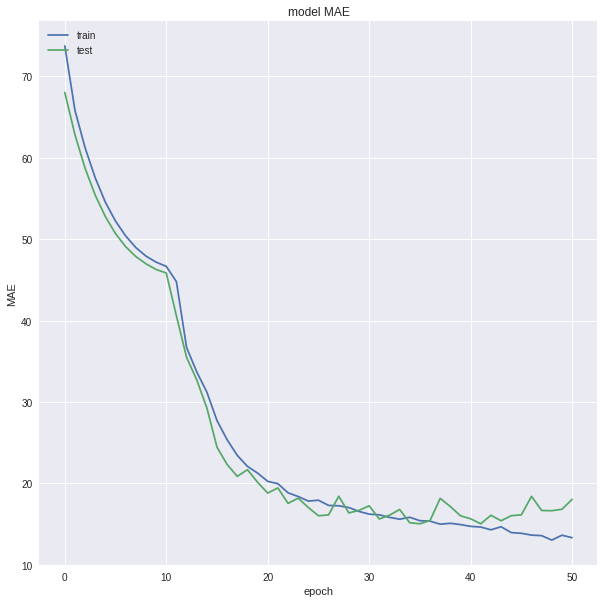

In [0]:

# summarize for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_mae.png")

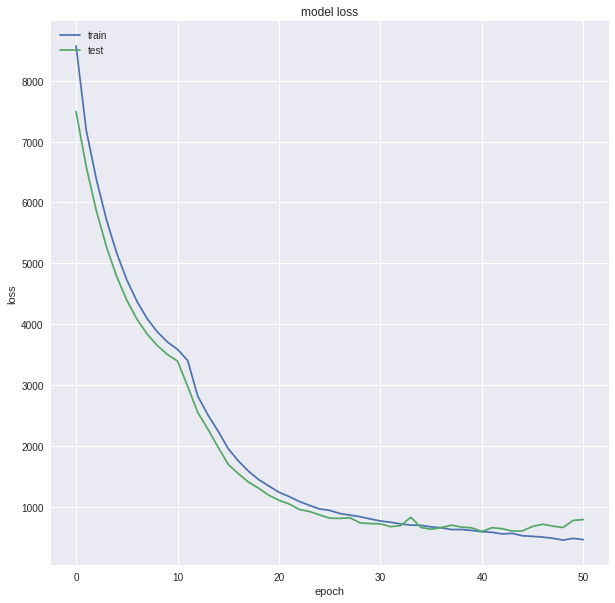

In [0]:
# summarize for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_regression_loss.png")


In [0]:

# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

15631/15631 [==============================] - 10s 632us/step

MAE: 12.8873427792

R^2: 0.845914890179


In [0]:

# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

15631/15631 [==============================] - 9s 602us/step

MAE: 12.8873427792

R^2: 0.845914890179


In [0]:
y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array
submit = np.concatenate((y_pred, y_true), axis=1)
print(submit)

test_set = pd.DataFrame(y_pred)
test_set.to_csv('submit_train.csv', index = None)


15631/15631 [==============================] - 11s 694us/step
[[167.04555   141.       ]
 [167.08537   140.       ]
 [167.15881   139.       ]
 ...
 [  6.1753016   2.       ]
 [  5.2615843   1.       ]
 [  4.3834743   0.       ]]


In [0]:
# We pick the last sequence for each id in the test data
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
#print("seq_array_test_last")
#print(seq_array_test_last)
#print(seq_array_test_last)

# Similarly, we pick the labels
#print("y_mask")
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
print(label_array_test_last.shape)
#print("label_array_test_last")
#print(label_array_test_last)


(93, 1)


In [0]:
def score_cal(y_hat, Y_test):
    d   = y_hat - Y_test
    tmp = np.zeros(d.shape[0])
    for i in range(d.shape[0]):
        if d[i,0] >= 0:
           tmp[i] = np.exp( d[i,0]/12) - 1
        else:
           tmp[i] = np.exp(-d[i,0]/15) - 1
    return tmp 


MAE: 12.1544966339

R^2: 0.808128006997
[[ 69.         52.968273 ]
 [ 82.         82.10745  ]
 [ 91.         93.57657  ]
 [ 93.        135.11472  ]
 [ 91.        121.11202  ]
 [ 95.        108.42248  ]
 [111.        134.48988  ]
 [ 96.         81.43619  ]
 [ 97.        115.69501  ]
 [124.         99.673416 ]
 [ 95.         82.54708  ]
 [ 83.        134.01892  ]
 [ 84.         95.38766  ]
 [ 50.         58.02103  ]
 [ 28.         34.431725 ]
 [ 87.         83.15422  ]
 [ 16.         15.046949 ]
 [ 57.         65.06374  ]
 [113.        135.2911   ]
 [ 20.         23.232851 ]
 [119.        135.29082  ]
 [ 66.         70.30453  ]
 [ 97.        127.13726  ]
 [ 90.         95.34001  ]
 [115.         91.66168  ]
 [  8.          7.715071 ]
 [ 48.         45.03195  ]
 [106.        133.03381  ]
 [  7.          6.943398 ]
 [ 11.         15.267223 ]
 [ 19.         23.581934 ]
 [ 21.         34.633102 ]
 [ 50.         61.723606 ]
 [ 28.         27.231415 ]
 [ 18.         39.47929  ]
 [ 10.        

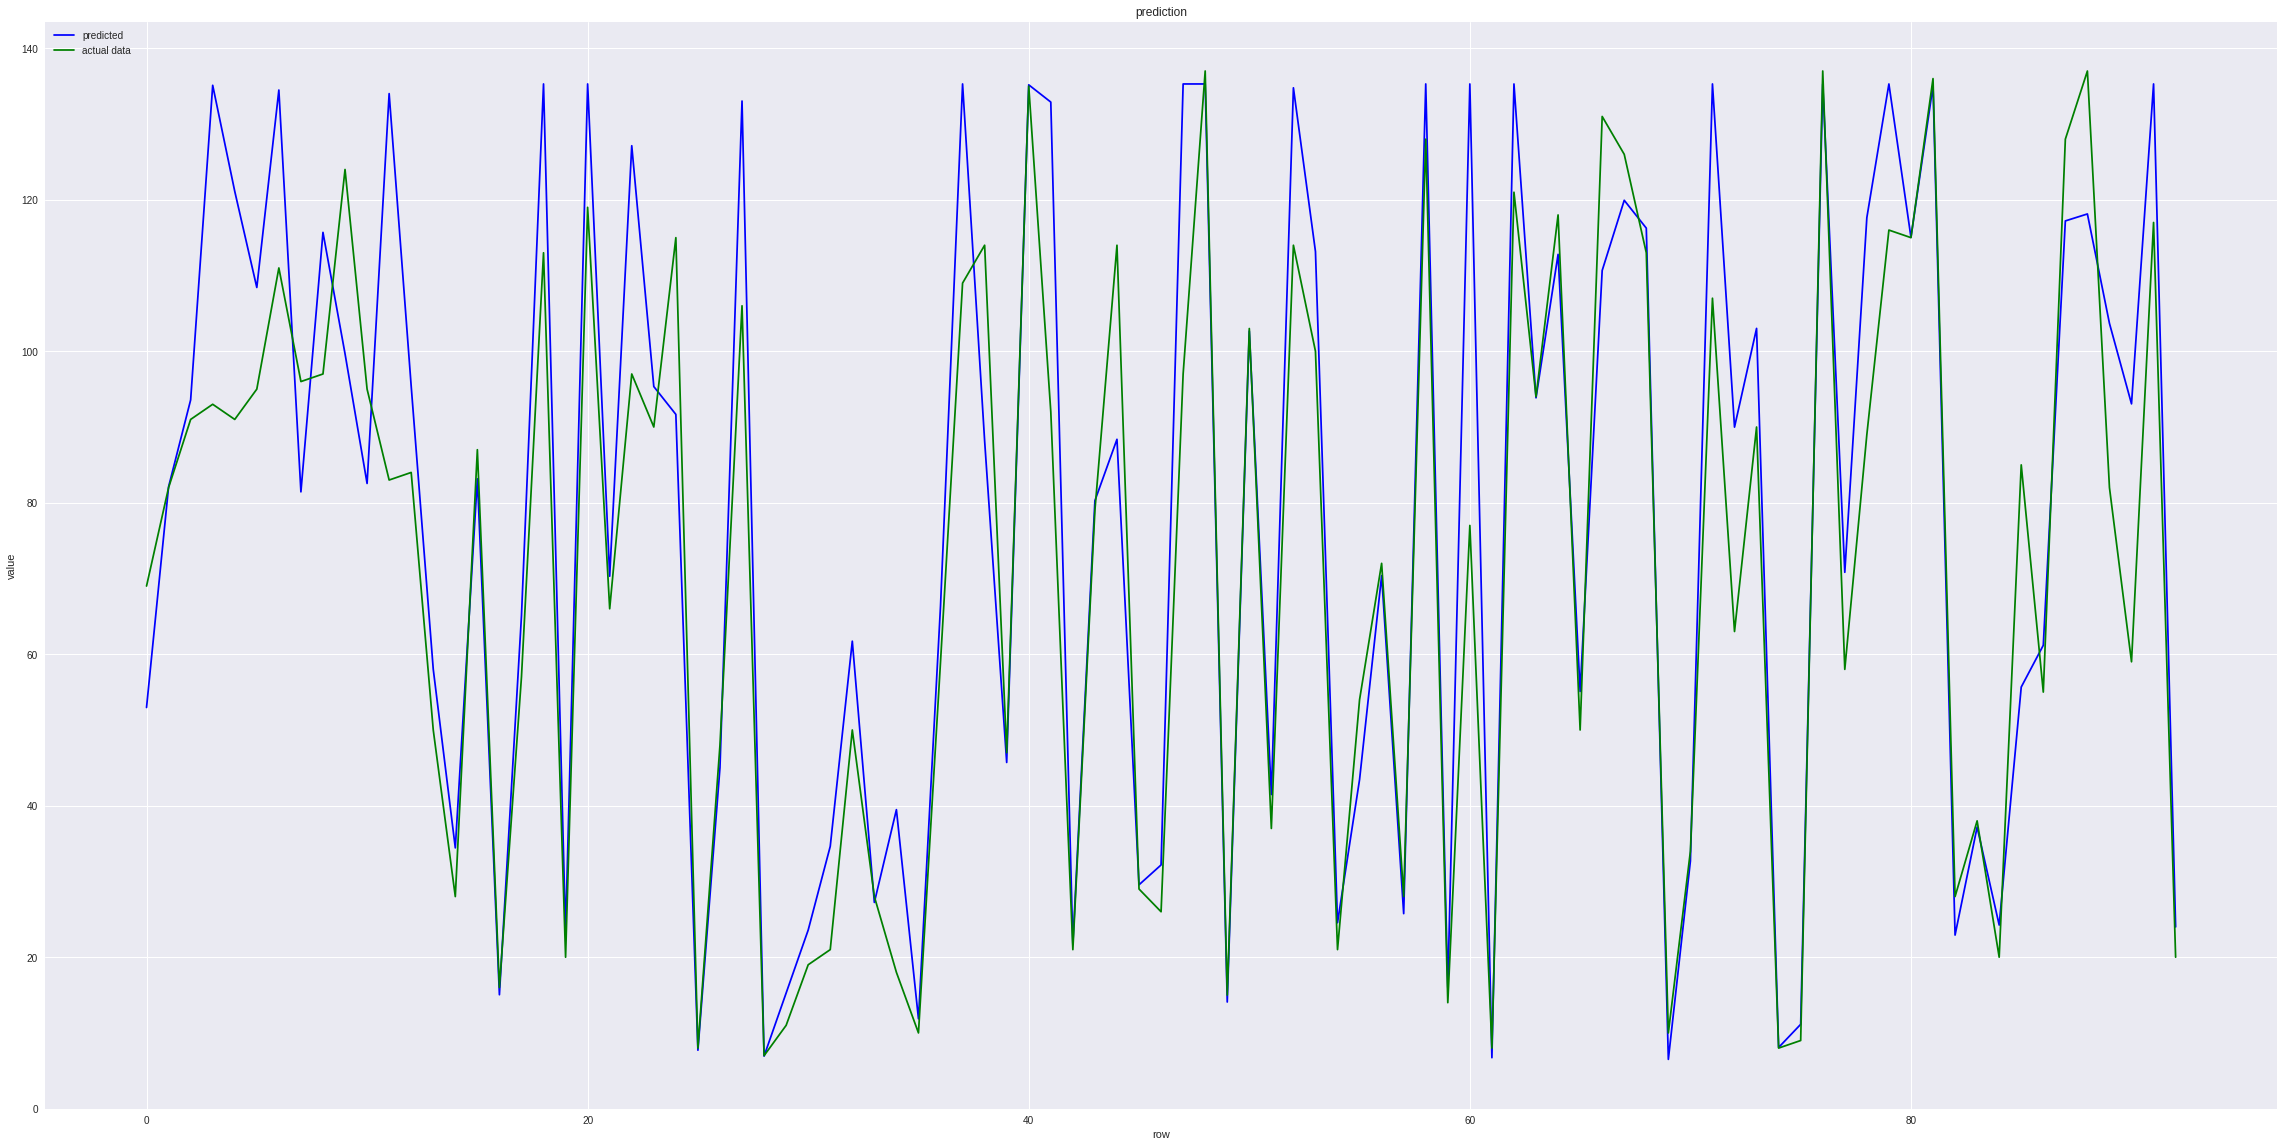

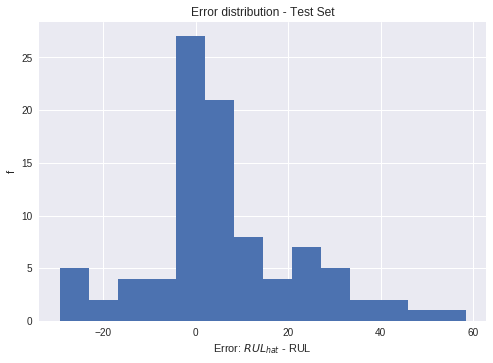

Score = 470.82114803349236


In [0]:
# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path,custom_objects={'r2_keras': r2_keras})

    # test metrics
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))

    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last

    test_set = pd.DataFrame(y_pred_test)
    submit = np.concatenate((y_true_test, y_pred_test), axis=1)
    print(submit)
    test_set.to_csv('submit_test.csv', index = None)

    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(40, 20))
    plt.plot(y_pred_test, color="blue")
    plt.plot(y_true_test, color="green")
    plt.title('prediction')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()
    fig_verify.savefig("model_regression_verify.png")
    
    d = y_pred_test - y_true_test
    plt.hist(d, bins='auto')  
    plt.title('Error distribution - Test Set')
    plt.ylabel('f')
    plt.xlabel("Error: $RUL_{hat}$ - RUL")
    plt.show()
    
    score_i_tr = score_cal(y_pred_test, y_true_test)
    print("Score = " + str(sum(score_i_tr)))